**D1 accuracy scoring; honeycomb and square lattices, AutoMod and MagicDNA**

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy

from scipy.spatial.transform import Rotation as R
from matplotlib.transforms import ScaledTranslation
import scipy.integrate as integrate

In [2]:
nodes_fname = "nodes.txt"

d_max_mean = 10
d_max_pairs = 2.5

designs = []
labels = []

labels.append("Target")

plt.rcParams["font.sans-serif"] = ['Arial']

In [3]:
# Honeycomb lattice, AutoMod
oxdna_fname = "hc_automod_mean.conf"
pairs_fname = "hc_automod_pairs.txt"

oxdna_h_inds = {0: list(range(4557, 5667+1))[::-1],
               1: list(range(3330, 4556+1)),
               2: list(range(2109, 3329+1))[::-1],
               3: list(range(998, 2108+1)),
               4: list(range(0, 997+1))[::-1],
               5: list(range(5668, 6668+1))}

designs.append([oxdna_fname, pairs_fname, oxdna_h_inds])
labels.append("AutoMod")

In [4]:
# Honeycomb lattice, MagicDNA
oxdna_fname = "hc_magicdna_mean.conf"
pairs_fname = "hc_magicdna_pairs.txt"

oxdna_h_inds = {0: list(range(5457, 6511+1)) + list(range(9, 128+1)),
               1: list(range(129, 1205+1))[::-1],
               2: list(range(1206, 2197+1)),
               3: list(range(2198, 3196+1))[::-1],
               4: list(range(3197, 4276+1)),
               5: list(range(4277, 5456+1))[::-1]}

designs.append([oxdna_fname, pairs_fname, oxdna_h_inds])
labels.append("MagicDNA")

In [5]:
# Square lattice, AutoMod
oxdna_fname = "sq_automod_mean.conf"
pairs_fname = "sq_automod_pairs.txt"

oxdna_h_inds = {0: list(range(5772, 6690+1)),
               1: list(range(6691, 7602+1))[::-1],
               2: list(range(7603, 8508+1)),
               3: list(range(8509, 9551+1))[::-1],
               4: list(range(3671, 4715+1)),
               5: list(range(4716, 5771+1))[::-1],
               6: list(range(1316, 2493+1)),
               7: list(range(2494, 3670+1))[::-1],
               8: list(range(9552, 10717+1)),
               9: list(range(10718, 12020+1))[::-1],
               10: list(range(12021, 13331+1)),
               11: list(range(153, 1315+1))[::-1]}

designs.append([oxdna_fname, pairs_fname, oxdna_h_inds])
labels.append("AutoMod")

In [6]:
# Square lattice, MagicDNA
oxdna_fname = "sq_magicdna_mean.conf"
pairs_fname = "sq_magicdna_pairs.txt"

oxdna_h_inds = {0: list(range(7415, 8328+1)),
               1: list(range(6511, 7414+1))[::-1],
               2: list(range(5595, 6510+1)),
               3: list(range(4585, 5594+1))[::-1],
               4: list(range(3576, 4584+1)),
               5: list(range(8329, 9340+1))[::-1],
               6: list(range(9341, 10462+1)),
               7: list(range(2468, 3575+1))[::-1],
               8: list(range(1349, 2467+1)),
               9: list(range(128, 1348+1))[::-1],
               10: list(range(11683, 12776+1)) + list(range(0, 127+1)),
               11: list(range(10463, 11682+1))[::-1]}

designs.append([oxdna_fname, pairs_fname, oxdna_h_inds])
labels.append("MagicDNA")

In [7]:
def read_nucleotide_positions(fname1, fname2, nucleotides):
    pos = np.zeros((len(nucleotides), 3))
    pairs = {}
    n_pairs = 0
    with open(fname2, 'r') as file2:
        pairs_lines = file2.readlines()
        for pairs_line in pairs_lines:
            try:
                inds = pairs_line.split(" ")
                pairs[int(inds[0])] = int(inds[1])
                pairs[int(inds[1])] = int(inds[0])
            except:
                pass
    with open(fname1, 'r') as file1:
        lines = file1.readlines()
        for i, nucleotide in enumerate(nucleotides):
            line = lines[nucleotide + 3]
            line_content = line.split(" ")
            pos[i, :] = line_content[0:3]
            try:
                pair = pairs[nucleotide]
                pair_line = lines[pair + 3]
                pair_line_content = pair_line.split(" ")
                d = np.sqrt((pos[i, 0] - float(pair_line_content[0]))**2 + (pos[i, 1] - float(pair_line_content[1]))**2 + (pos[i, 2] - float(pair_line_content[2]))**2)
                n_pairs += 1
                if d*0.8518 <= d_max_pairs:
                    pos[i, 0] = (pos[i, 0] + float(pair_line_content[0])) / 2
                    pos[i, 1] = (pos[i, 1] + float(pair_line_content[1])) / 2
                    pos[i, 2] = (pos[i, 2] + float(pair_line_content[2])) / 2
            except KeyError:
                # print('No pair found for {:}.'.format(nucleotide))
                pass
    pos = 0.8518 * pos  # from simulation units to nm
    return pos, n_pairs


def solve_splines(x, y):
    count = len(x)
    a = np.copy(y)
    b = np.zeros(count - 1)
    d = np.zeros(count - 1)
    h = np.zeros(count - 1)
    alpha = np.zeros(count - 1)
    for i in range(0, count - 1):
        h[i] = x[i + 1] - x[i]
    for i in range(1, count - 1):
        alpha[i] = (3 / h[i]) * (a[i + 1] - a[i]) - (3 / h[i - 1]) * (a[i] - a[i - 1])
    c = np.zeros(count)
    l = np.zeros(count)
    l[0] = 1
    mu = np.zeros(count)
    z = np.zeros(count)
    for i in range(1, count - 1):
        l[i] = 2 * (x[i + 1] - x[i - 1]) - h[i - 1] * mu[i - 1]
        mu[i] = h[i] / l[i]
        z[i] = (alpha[i] - h[i - 1] * z[i - 1]) / l[i]
    l[count - 1] = 1
    for j in range(count - 2, -1, -1):
        c[j] = z[j] - mu[j] * c[j + 1]
        b[j] = (a[j + 1] - a[j]) / h[j] - (h[j] * (c[j + 1] + 2 * c[j])) / 3
        d[j] = (c[j + 1] - c[j]) / (3 * h[j])
    return np.stack((a[0:count - 1], b[0:count - 1], c[0:count - 1], d[0:count - 1], x[0:count - 1]))


def spline_point(t_p, P_x, P_y, P_z, t):
    for i in range(len(P_x[0, :])):
        if P_x[4, i] <= t_p <= t[i+1]:
            x = P_x[0, i] + P_x[1, i]*(t_p - P_x[4, i]) + P_x[2, i]*(t_p - P_x[4, i])**2 + P_x[3, i]*(t_p - P_x[4, i])**3
            y = P_y[0, i] + P_y[1, i]*(t_p - P_y[4, i]) + P_y[2, i]*(t_p - P_y[4, i])**2 + P_y[3, i]*(t_p - P_y[4, i])**3
            z = P_z[0, i] + P_z[1, i]*(t_p - P_z[4, i]) + P_z[2, i]*(t_p - P_z[4, i])**2 + P_z[3, i]*(t_p - P_z[4, i])**3
            return np.array([x, y, z])

        
def spline_derivative(t_p, P_x, P_y, P_z, t):
    for i in range(len(P_x[0, :])):
        if P_x[4, i] <= t_p <= t[i+1]:
            x = P_x[1, i] + 2*P_x[2, i]*(t_p - P_x[4, i]) + 3*P_x[3, i]*(t_p - P_x[4, i])**2
            y = P_y[1, i] + 2*P_y[2, i]*(t_p - P_y[4, i]) + 3*P_y[3, i]*(t_p - P_y[4, i])**2
            z = P_z[1, i] + 2*P_z[2, i]*(t_p - P_z[4, i]) + 3*P_z[3, i]*(t_p - P_z[4, i])**2
            return np.sqrt(x**2 + y**2 + z**2)

        
def construct_splines(nodes):
    splines = {}
    for h, node_array in nodes.items():
        t = np.linspace(0, 1, node_array.shape[0])
        Px = solve_splines(t, node_array[:, 0])
        Py = solve_splines(t, node_array[:, 1])
        Pz = solve_splines(t, node_array[:, 2])
        splines[h] = [t, Px, Py, Pz]
    return splines


def read_nodes(fname):
    nodes = []
    nodes_arrays = {}
    with open(fname, 'r') as file:
        lines = file.readlines()
        for line in lines:
            coords = line.split(",")
            if len(coords) == 3:
                nodes.append(np.array([float(coords[0]), float(coords[1]), float(coords[2])]))
    node_pos = np.zeros((len(nodes), 3))
    for i in range(len(nodes)):
        node_pos[i, :] = nodes[i]
    nodes_arrays[0] = node_pos
    return nodes_arrays


def sample_from_splines_uniformly(splines, min_l):
    pos_dct = {}
    for h, spline_lst in splines.items():
        t = spline_lst[0]
        Px = spline_lst[1]
        Py = spline_lst[2]
        Pz = spline_lst[3]
        array = np.zeros((min_l, 3))
        l_tot, _ = integrate.quad(spline_derivative, 0, 1, args=(Px, Py, Pz, t), limit=150)
        count = 0
        for i in range(1, len(t)):
            l_seg, _ = integrate.quad(spline_derivative, t[i-1], t[i], args=(Px, Py, Pz, t))
            n_points = int(np.round((l_seg / l_tot) * min_l))
            if i == len(t)-1 and n_points + count < min_l:
                n_points += 1
            t_p = np.linspace(t[i-1], t[i], n_points, endpoint=False)
            for j in range(n_points):
                if count + j < min_l:
                    array[count + j, :] = spline_point(t_p[j], Px, Py, Pz, t)
            count += n_points
        pos_dct[h] = array
    return pos_dct


def get_oxdna(ind_dct, fname1, fname2):
    pos_dct = {}
    pair_counts = {}
    min_l = 100000
    for h_num, ind_list in ind_dct.items():
        pos_dct[h_num], pair_counts[h_num] = read_nucleotide_positions(fname1, fname2, ind_list)
        if pos_dct[h_num].shape[0] < min_l:
            min_l = pos_dct[h_num].shape[0]
    mean_pos = np.zeros((1, 3))
    for h_num, pos in pos_dct.items():
        if pos.shape[0] > min_l:
            pos_dct[h_num] = pos[np.linspace(0, pos.shape[0]-1, min_l, dtype=np.int32), :]
        mean_pos += np.sum(pos_dct[h_num], axis=0) * (1/min_l)
    mean_pos = mean_pos / len(pos_dct)
    for h_num, pos in pos_dct.items():
        pos_dct[h_num] = pos - mean_pos
    return pos_dct, min_l, pair_counts


def get_target(fname, min_l):
    nodes = read_nodes(fname)
    splines = construct_splines(nodes)
    pos_dct = sample_from_splines_uniformly(splines, min_l)
    mean_pos = np.zeros((1, 3))
    for h_num, pos in pos_dct.items():
        mean_pos += np.sum(pos_dct[h_num], axis=0) * (1/min_l)
    mean_pos = mean_pos / len(pos_dct)
    for h_num, pos in pos_dct.items():
        pos_dct[h_num] = pos - mean_pos
    return pos_dct


def align_b_to_a(a, b):
    rot, rssd, sens = R.align_vectors(a, b, return_sensitivity=True)
    rot.as_matrix()
    new_b = rot.apply(b)
    return rot, new_b, rssd

In [8]:
positions = []
for design in designs:
    oxdna_pos, min_l, pair_counts = get_oxdna(design[2], design[0], design[1])
    target_pos = get_target(nodes_fname, min_l)
    positions.append([oxdna_pos, min_l, target_pos])

In [9]:
mean_results = []
alignments = []
for position in positions:
    
    oxdna_mean = np.zeros((position[1], 3))
    for h, pos in position[0].items():
        oxdna_mean = np.add(oxdna_mean, pos)
    oxdna_mean = oxdna_mean / len(position[0])

    target_mean = np.zeros((position[1], 3))
    for h, pos in position[2].items():
        target_mean = np.add(target_mean, pos)
    target_mean = target_mean / len(position[2])

    rot_mat, new_pos, rssd = align_b_to_a(target_mean, oxdna_mean)
    alignments.append(rot_mat)
    
    correct = 0
    green_pos = []
    red_pos = []
    d_vals_in = []
    d_vals_out = []
    for i in range(position[1]):
        d = np.sqrt(np.sum(np.square(new_pos[i, :] - target_mean[i, :])))
        if d <= d_max_mean:
            correct += 1
            green_pos.append(new_pos[i, :])
            d_vals_in.append(d)
        else:
            red_pos.append(new_pos[i, :])
            d_vals_out.append(d)
    acc = 100*correct/position[1]

    greens = np.asarray(green_pos)
    reds = np.asarray(red_pos)
    mean_results.append([greens, reds, np.sqrt(rssd**2/position[1]), acc, d_vals_in, d_vals_out])

<IPython.core.display.Javascript object>


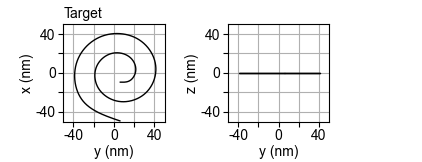

<IPython.core.display.Javascript object>


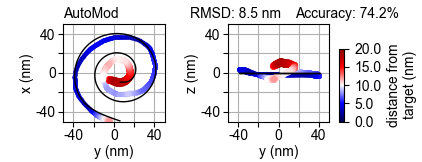

<IPython.core.display.Javascript object>


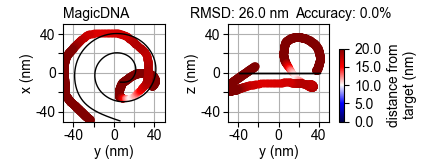

<IPython.core.display.Javascript object>


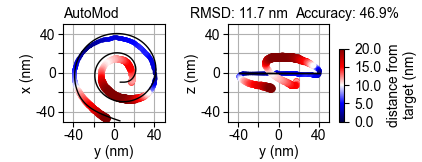

<IPython.core.display.Javascript object>


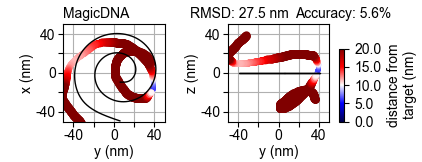

In [10]:
cm = (1/2.54)

for i in range(len(labels)):
    f = plt.figure(figsize=(0.65*16.5*cm, 0.25*16.5*cm))
    for j in range(2):
        ax = f.add_subplot(1, 2, j+1, position=[0.15+j*(1-2*0.15-0.22)/2+j*0.15, 0.25, (1-2*0.15-0.22)/2, 1-0.4])
        if j % 2 == 0:
            ax.set_xlim(-50, 50); ax.set_ylim(-50, 50);
            ax.tick_params(labelsize=10, pad=2)
            ax.set_xticks([-40, -20, 0 , 20, 40], labels=["-40", "", "0", "", "40"])
            ax.set_yticks([-40, -20, 0, 20, 40], labels=["-40", "", "0", "", "40"])
            ax.set_xlabel("y (nm)", labelpad=1, fontsize=10);
            ax.set_ylabel("x (nm)", labelpad=1, fontsize=10);
            ax.plot(target_mean[:, 1], -target_mean[:, 0], 'k', linewidth=1, zorder=10);
        else:
            ax.set_xlim(-50, 50); ax.set_ylim(-50, 50);
            ax.tick_params(labelsize=10, pad=2)
            ax.set_xticks([-40, -20, 0, 20, 40], labels=["-40", "", "0", "", "40"])
            ax.set_yticks([-40, -20, 0, 20, 40], labels=["-40", "", "0", "", "40"])
            ax.set_xlabel("y (nm)", labelpad=1, fontsize=10);
            ax.set_ylabel("z (nm)", labelpad=1, fontsize=10);
            ax.plot(target_mean[:, 1], target_mean[:, 2], 'k', linewidth=1, zorder=10);
            if i > 0:
                cax = ax.inset_axes([1.1, 0, 0.05, 0.75])
        ax.grid(True);
        if i > 0:
            cmap = mpl.colormaps['seismic']
            cmax = d_max_mean
            mean_results[i-1][4] 
            for l in range(len(mean_results[i-1][4])):
                d_val = mean_results[i-1][4][l]
                cval = ((-1) * min(np.abs(d_val-d_max_mean), cmax) / (2*cmax)) + (1/2)
                color = cmap(cval)
                ms = cval * 4 + 1
                if j % 2 == 0:
                    ax.plot(mean_results[i-1][0][l, 1], -mean_results[i-1][0][l, 0], linewidth=0, marker='o', markersize=ms, color=color);
                else:
                    ax.plot(mean_results[i-1][0][l, 1], mean_results[i-1][0][l, 2], linewidth=0, marker='o', markersize=ms, color=color);
            for k in range(len(mean_results[i-1][5])):
                d_val = mean_results[i-1][5][k]
                cval = ((+1) * min(np.abs(d_val-d_max_mean), cmax) / (2*cmax)) + (1/2)
                color = cmap(cval)
                ms = cval * 4 + 1
                if j % 2 == 0:
                    ax.plot(mean_results[i-1][1][k, 1], -mean_results[i-1][1][k, 0], linewidth=0, marker='o', markersize=ms, color=color)
                else:
                    ax.plot(mean_results[i-1][1][k, 1], mean_results[i-1][1][k, 2], linewidth=0, marker='o', markersize=ms, color=color)
        if i > 0 and j % 2 == 1:
            cbar = f.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=mpl.colormaps['seismic']), cax=cax, location='right', ticks=[0.00, 0.25, 0.5, 0.75, 1.00])
            cbar.ax.set_yticklabels(['0.0', '5.0', '10.0', '15.0', '20.0'], fontsize=10)
            cbar.set_label("distance from\ntarget (nm)", fontsize=10)
    plt.figtext(0.15, 0.87, labels[i], fontsize=10, ha='left', va='bottom');
    if i > 0:
        plt.figtext(0.45, 0.87, "RMSD: {:.1f} nm".format(mean_results[i-1][2]), fontsize=10, ha='left', va='bottom');
        plt.figtext(0.70, 0.87, "Accuracy: {:.1f}%".format(mean_results[i-1][3]), fontsize=10, ha='left', va='bottom');
    f.savefig("panel_{:d}.png".format(i), dpi=900, transparent=True)